# Image Denoising Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a denoising model. For a given noisy image $X$, our model should learn to predict the denoised image $y$.


**Objectives**
- Visualize images
- Preprocess images for the neural network
- Fit a custom CNN for the task

## 1. Load Data

👉 Let's download the dataset archive.
It contains RGB and Black & White images we will be using for the rest of this challenge.

In [1]:
! curl https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/paintings.zip > paintings.zip
! unzip -nq "paintings.zip" 
! rm "paintings.zip"
! ls -l

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  3 90.1M    3 3215k    0     0  5112k      0  0:00:18 --:--:--  0:00:18 5112k
 12 90.1M   12 11.1M    0     0  7058k      0  0:00:13  0:00:01  0:00:12 7053k
 50 90.1M   50 45.2M    0     0  17.3M      0  0:00:05  0:00:02  0:00:03 17.3M
 78 90.1M   78 71.1M    0     0  19.6M      0  0:00:04  0:00:03  0:00:01 19.6M
100 90.1M  100 90.1M    0     0  20.6M      0  0:00:04  0:00:04 --:--:-- 20.6M


total 82676
-rw-r--r-- 1 emman 197609 82812928 Jun 30 10:32 data_painting_solution.pickle
-rw-r--r-- 1 emman 197609  1447324 Jun 30 12:59 image_denoising.ipynb
drwxr-xr-x 1 emman 197609        0 Jun  9 15:06 paintings
-rw-r--r-- 1 emman 197609        0 Jun 29 09:18 README.md
drwxr-xr-x 1 emman 197609        0 Jun 30 12:39 tests


In [2]:
import glob
from os import listdir
from PIL import Image as PImage
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error

In [3]:
dataset_paths = glob.glob("./paintings/*.jpg")
dataset_paths

['./paintings\\Albrecht_Duâ\x95\xa0Ãªrer_107.jpg',
 './paintings\\Albrecht_Duâ\x95\xa0Ãªrer_114.jpg',
 './paintings\\Albrecht_Duâ\x95\xa0Ãªrer_121.jpg',
 './paintings\\Albrecht_Duâ\x95\xa0Ãªrer_129.jpg',
 './paintings\\Albrecht_Duâ\x95\xa0Ãªrer_136.jpg',
 './paintings\\Albrecht_Duâ\x95\xa0Ãªrer_143.jpg',
 './paintings\\Albrecht_Duâ\x95\xa0Ãªrer_150.jpg',
 './paintings\\Albrecht_Duâ\x95\xa0Ãªrer_158.jpg',
 './paintings\\Albrecht_Duâ\x95\xa0Ãªrer_165.jpg',
 './paintings\\Albrecht_Duâ\x95\xa0Ãªrer_17.jpg',
 './paintings\\Albrecht_Duâ\x95\xa0Ãªrer_172.jpg',
 './paintings\\Albrecht_Duâ\x95\xa0Ãªrer_187.jpg',
 './paintings\\Albrecht_Duâ\x95\xa0Ãªrer_194.jpg',
 './paintings\\Albrecht_Duâ\x95\xa0Ãªrer_200.jpg',
 './paintings\\Albrecht_Duâ\x95\xa0Ãªrer_208.jpg',
 './paintings\\Albrecht_Duâ\x95\xa0Ãªrer_215.jpg',
 './paintings\\Albrecht_Duâ\x95\xa0Ãªrer_22.jpg',
 './paintings\\Albrecht_Duâ\x95\xa0Ãªrer_222.jpg',
 './paintings\\Albrecht_Duâ\x95\xa0Ãªrer_237.j

❓ **Display the image at index `53` of this dataset_paths (i.e the 54-th image)**

<details>
    <summary>Hint</summary>
    Use the <code>PIL.Image.open</code> and <code>matplotlib.pyplot.imshow</code> functions.
</details>

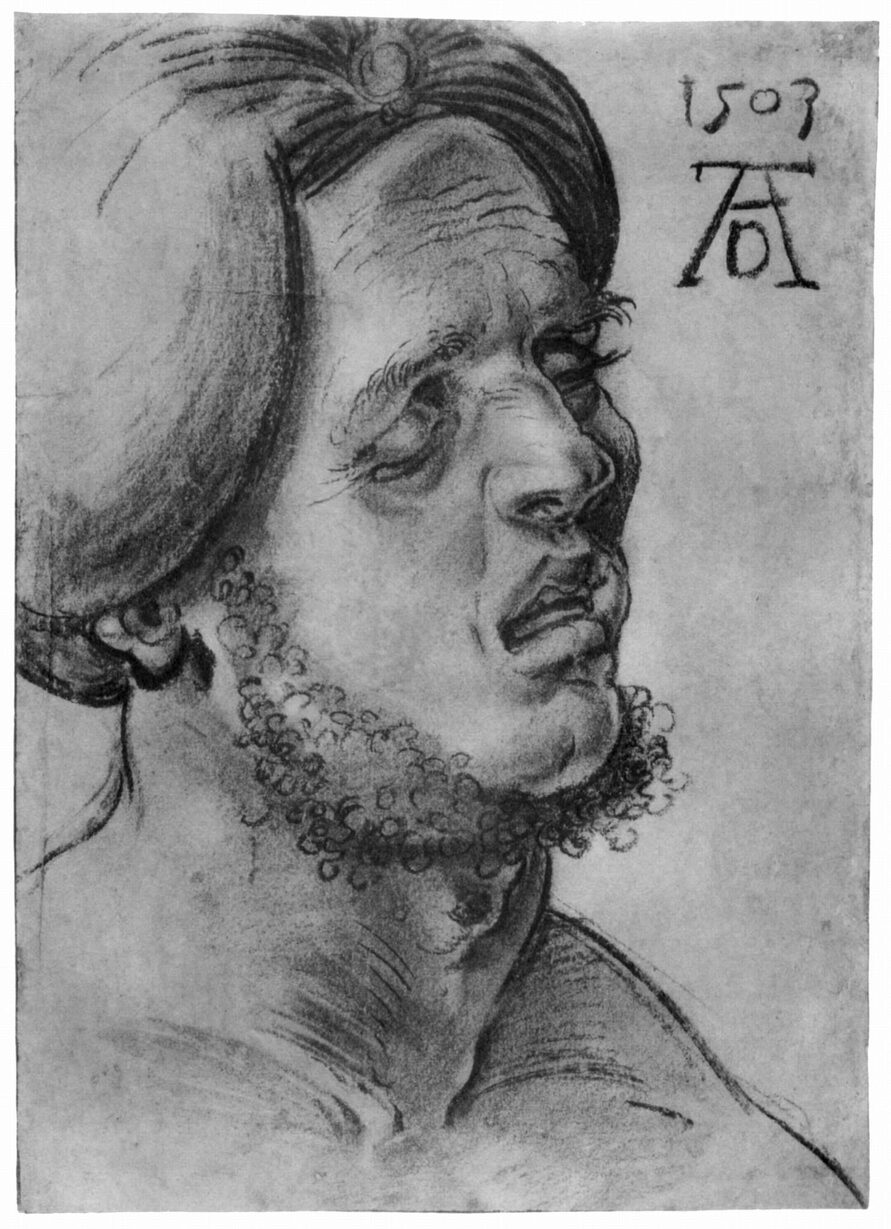

In [4]:
img=Image.open(dataset_paths[53])
display(img)

❓ **What is the shape of the image you displayed above `img_shape`?  How many dimensions `img_dim` does it have ?**

In [5]:
img_shape = np.asarray(img).shape
img_dim = np.asarray(img).ndim
print(img_shape)
print(img_dim)

(1229, 891)
2


❓ **What was in the image above?**

In [6]:
img_shape = img_shape
img_dim = img_dim

# Uncomment the correct answer

is_portrait = True
#is_portrait = False

#is_colored_image = True
is_colored_image = False

In [7]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    img_shape=img_shape,
    img_dim=img_dim,
    is_portrait=is_portrait,
    is_colored_image=is_colored_image
)

result.write()

## 2. Processing

❓ **Store all images from the dataset folder in a list of numpy arrays called `dataset_images`**

- It can take a while
- If the dataset is too big to fit in memory, just take the first half (or quarter) of all pictures

In [8]:
img_list=np.arange(len(dataset_paths))

dataset_images =[np.asarray(Image.open(dataset_paths[img])) for img in img_list]

### 2.1 Reshape, Resize, Rescale

Let's simplify our dataset and convert it to a single numpy array

❓ **First, check if that all the images in the dataset have the same number of dimensions**.
- What do you notice?
- How do you explain it? 

In [9]:
dataset_dim = [ img.ndim for img in dataset_images]

print(np.unique(np.array(dataset_dim)))

[2 3]


In [10]:
explain_answer= """
There are 2 dimensions for black & white images 
There are 3 dimensions for colored images (one each for red, green, and blue channels)
"""

👉 We convert for you all black & white images into 3-colored ones by duplicating the image on three channels, so as to have only 3D arrays

In [11]:
dataset_images = [x if x.ndim==3 else np.repeat(x[:,:,None], 3, axis=2) for x in tqdm(dataset_images)]
set([x.ndim for x in dataset_images])

100%|██████████| 1085/1085 [00:00<00:00, 2234.63it/s]


{3}

❓ **What about their shape now ?**
- Do they all have the same width/heights ? If not:
- Resize the images (120 pixels height and 100 pixels width) in the dataset, using `tensorflow.image.resize` function.
- Now that they all have the same shape, store them as a numpy array `dataset_resized`.
- This array should thus be of size $(n_{images}, 120, 100, 3)$

In [12]:
list_resized = [ tf.image.resize(img, [120,100]) for img in dataset_images]
list_resized[1].shape

TensorShape([120, 100, 3])

In [13]:
dataset_resized = np.asarray(list_resized)
dataset_resized[1]

array([[[ 29.247665,  29.247665,  29.247665],
        [ 31.6535  ,  31.6535  ,  31.6535  ],
        [ 51.968334,  51.968334,  51.968334],
        ...,
        [164.26915 , 164.26915 , 164.26915 ],
        [158.40767 , 158.40767 , 158.40767 ],
        [164.17625 , 164.17625 , 164.17625 ]],

       [[ 23.279501,  23.279501,  23.279501],
        [ 15.902501,  15.902501,  15.902501],
        [ 16.434998,  16.434998,  16.434998],
        ...,
        [151.86497 , 151.86497 , 151.86497 ],
        [146.7726  , 146.7726  , 146.7726  ],
        [145.00801 , 145.00801 , 145.00801 ]],

       [[ 18.1825  ,  18.1825  ,  18.1825  ],
        [ 18.7125  ,  18.7125  ,  18.7125  ],
        [ 13.799999,  13.799999,  13.799999],
        ...,
        [162.07079 , 162.07079 , 162.07079 ],
        [163.3709  , 163.3709  , 163.3709  ],
        [150.56993 , 150.56993 , 150.56993 ]],

       ...,

       [[137.16742 , 137.16742 , 137.16742 ],
        [157.93105 , 157.93105 , 157.93105 ],
        [173.20404 , 1

❓ **Rescale the data of each image between $0$ and $1$**
- Save your resulting list as `dataset_scaled`

In [14]:
dataset_scaled = np.divide(dataset_resized,255)


### 2.2 Create (X,y) sets

👉 Now, we'll add for you some **random noise** to our images to simulate noise (that our model will try to remove later)

In [15]:
NOISE_LEVEL = 0.2

dataset_noisy = np.clip(
    dataset_scaled + np.random.normal(
        loc=0,
        scale=NOISE_LEVEL,
        size=dataset_scaled.shape
    ).astype(np.float32),
    0,
    1
)
dataset_noisy.shape

(1085, 120, 100, 3)

❓ **Plot a noisy image below to visualize the noise and compare it with the normal one**

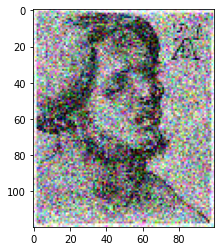

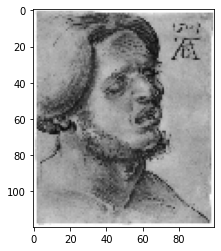

In [16]:
plt.imshow(dataset_noisy[53])
plt.show()
plt.imshow(dataset_scaled[53])
plt.show()

❓ **Create your `(X_train, Y_train)`, `(X_test, Y_test)` training set for your problem**

- Remember you are trying to use "noisy" pictures in order to predict the "normal" ones.
- Keeping about `20%` of randomly sampled data as test set

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset_noisy, dataset_scaled, test_size=0.2)

In [18]:
from nbresult import ChallengeResult
result = ChallengeResult(
    "preprocessing",
    X_train_shape = X_train.shape,
    Y_train_shape = Y_train.shape,
    X_std = X_train[:,:,:,0].std(),
    Y_std = Y_train[:,:,:,0].std(),
    first_image = Y_train[0]
)
result.write()

## 3. Convolutional Neural Network

A commonly used neural network architecture for image denoising is the __AutoEncoder__.

<img src='https://github.com/lewagon/data-images/blob/master/DL/autoencoder.png?raw=true'>

Its goal is to learn a compact representation of your data to reconstruct them as precisely as possible.  
The loss for such model must incentivize it to have __an output as close to the input as possible__.

For this challenge, __you will only be asked to code the Encoder part of the network__, since building a Decoder leverages layers architectures you are not familiar with (yet).

👉 Run this code below if you haven't managed to build your own (X,Y) training sets. This will load them as solution

```python
! curl https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_painting_solution.pickle > data_painting_solution.pickle

import pickle
with open("data_painting_solution.pickle", "rb") as file:
    (X_train, Y_train, X_test, Y_test) = pickle.load(file)
    
! rm data_painting_solution.pickle
```

### 3.1 Architecture

👉 Run the cell below that defines the decoder

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, losses, Sequential

In [20]:
# We choose to compress images into a latent_dimension of size 6000
latent_dimensions = 6000

# We build a decoder that takes 1D-vectors of size 6000 to reconstruct images of shape (120,100,3)
decoder = Sequential(name='decoder')
decoder.add(layers.Reshape((30, 25, 8), input_dim=latent_dimensions))
decoder.add(layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding="same", activation="relu"))
decoder.add(layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding="same", activation="relu"))
decoder.add(layers.Conv2D(filters=3, kernel_size=3, padding="same", activation="sigmoid"))
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 30, 25, 8)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 60, 50, 16)        1168      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 120, 100, 32)      4640      
_________________________________________________________________
conv2d (Conv2D)              (None, 120, 100, 3)       867       
Total params: 6,675
Trainable params: 6,675
Non-trainable params: 0
_________________________________________________________________


❓ **Now, build the `encoder` that plugs correctly with the decoder defined above**. Make sure that:
- The output of your `encoder` is the same shape as the input of the `decoder`
- Use a convolutional neural network architecture without transfer learning
- Keep it simple
- Print model summary

In [21]:

encoder = Sequential(name='encoder')
encoder.add(layers.Conv2DTranspose(filters=3,input_shape=(120, 100, 3), kernel_size=3, padding="same", activation="sigmoid"))
encoder.add(layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
encoder.add(layers.Conv2D(filters=16, kernel_size=3,strides=2, padding="same", activation="relu"))
encoder.add(layers.Conv2D(filters=8, kernel_size=3,strides=2, padding="same", activation="linear"))
encoder.add(layers.Flatten())

encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_2 (Conv2DTr (None, 120, 100, 3)       84        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 100, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 50, 16)        4624      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 25, 8)         1160      
_________________________________________________________________
flatten (Flatten)            (None, 6000)              0         
Total params: 6,764
Trainable params: 6,764
Non-trainable params: 0
_________________________________________________________________


👉 **Test your encoder below**

In [22]:
# HERE WE BUILD THE AUTO-ENCODER (ENCODER + DECODER) FOR YOU. IT SHOULD PRINT A NICE SUMMARY
from tensorflow.keras.models import Model

x = layers.Input(shape=(120, 100, 3))
autoencoder = Model(x, decoder(encoder(x)), name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 100, 3)]     0         
_________________________________________________________________
encoder (Sequential)         (None, 6000)              6764      
_________________________________________________________________
decoder (Sequential)         (None, 120, 100, 3)       6675      
Total params: 13,439
Trainable params: 13,439
Non-trainable params: 0
_________________________________________________________________


### 3.2 Training

❓ **Before training the autoencoder, evaluate your baseline score**
- We will use the mean absolute error in this challenge
- Compute the baseline score on your test set in the "stupid" case where you don't manage to de-noise anything at all.
- Store the result under `score_baseline`

In [23]:
Y_pred_baseline = X_test
score_baseline = (np.absolute(Y_test - Y_pred_baseline)).mean()
score_baseline

0.14183287

❓ Now, **train your autoencoder**

- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 5 minutes of training without GPUs.

In [24]:
autoencoder.compile(loss='mse',
                  optimizer='adam',
                  metrics=['mae'])


es = EarlyStopping(patience=5, restore_best_weights=True)

history = autoencoder.fit(X_train, Y_train,
          validation_split=0.2,
          epochs=50, 
          batch_size=32,
          verbose=0,
          callbacks=[es])

❓ **Plot your training and validation loss at each epoch using the cell below**

(<AxesSubplot:title={'center':'loss'}>, <AxesSubplot:title={'center':'mae'}>)

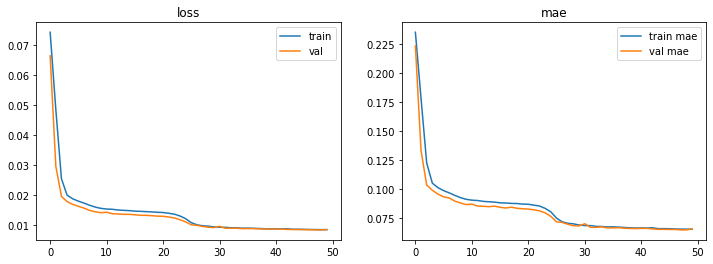

In [25]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label='train' + exp_name)
    ax1.plot(history.history['val_loss'], label='val' + exp_name)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['mae'], label='train mae'  + exp_name)
    ax2.plot(history.history['val_mae'], label='val mae'  + exp_name)
    ax2.set_title('mae')
    ax2.legend()
    return (ax1, ax2)

plot_history(history, title='', axs=None, exp_name="")

In [26]:
# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
plt.savefig("tests/history.png")

<Figure size 432x288 with 0 Axes>

❓ **Evaluate your performances on test set**
- Compute your de-noised test set `Y_pred` 
- Store your test score as `score_test`
- Plot a de-noised image from your test set and compare it with the original and noisy one using the cell below

In [27]:
Y_pred = autoencoder.predict(Y_test)
score_test = autoencoder.evaluate(X_test, Y_test, verbose=0)[1]
score_test

0.06787946075201035

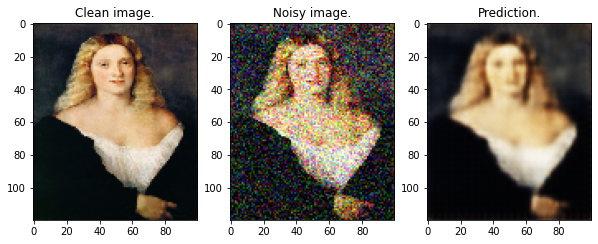

In [28]:
# RUN THIS CELL TO CHECK YOUR RESULTS
idx = 0

fig, axs = plt.subplots(1,3, figsize=(10,5))
axs[0].imshow(Y_test[idx])
axs[0].set_title("Clean image.")

axs[1].imshow(X_test[idx])
axs[1].set_title("Noisy image.")

axs[2].imshow(Y_pred[idx])
axs[2].set_title("Prediction.")

# Run this to save your results for correction
plt.savefig('tests/image_denoised.png')

🧪 **Send your results below**

In [29]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    input_shape = list(encoder.input.shape),
    output_shape = list(encoder.output.shape),
    layer_names = [layer.name for layer in encoder.layers],
    trainable_params = sum([tf.size(w_matrix).numpy() for w_matrix in encoder.trainable_variables]),
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()